# micrograd

Basic autograd engine implementation from the tutorial

In [666]:
import math
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [667]:
def f(x):
    return x**2 + 2*x + 1

In [668]:
f(8.0)

81.0

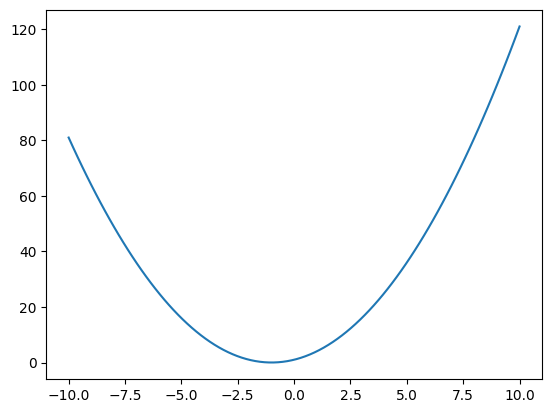

In [669]:
X = jnp.linspace(-10, 10, 100)
Y = f(X)

plt.plot(X, Y)

In [670]:
h = 0.0000000001
x = 3.0
(f(x + h) - f(x)) / h

8.000000661922968

In [671]:
a = 2.0
b = 1.0
c = 10.0

d = a * b + c

print(d)

12.0


In [672]:
h = 0.001

a = 2.0
b = -1.0
c = 10.0

d1 = a * b + c
d2 = (a + h) * b + c

print(f'd1: {d1}')
print(f'd2: {d2}')

slope = (d2 - d1) / h

print(f'slope: {slope}')

d1: 8.0
d2: 7.9990000000000006
slope: -0.9999999999994458


### Value

Basic scalar wrapper

In [673]:
class Value:

    def __init__(self, data, _children = (), _op = '', label = '', grad = 0.0):
        self.data =data
        self._pred = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f'Value(data = {self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+', f'{self.label} + {other.label}')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*', f'{self.label} * {other.label}')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        f = jnp.tanh(self.data)
        out = Value(f, (self,), 'tanh', f'tanh({self.label})')

        def _backward():
            self.grad = (1 - f**2) * out.grad
        out._backward = _backward

        return out


In [674]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(u):
        if u not in nodes:
            nodes.add(u)
            for v in u._pred:
                edges.add((v, u))
                build(v)
    
    build(root)
    return nodes, edges

def draw(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = f'{{ {n.label} | {n.data:.2f} | {n.grad:.2f} }}', shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n, m in edges:
        dot.edge(str(id(n)), str(id(m)) + m._op)

    return dot


In [675]:
a = Value(2.0, label = 'a')
b = Value(-1.0, label = 'b')
c = Value(10.0, label = 'c')

d = a * b + c
d.label = 'd'
print(d)  

e = a * b
e.label = 'e'
print(e)  

f = e + c
f.label = 'f'
print(f)  

g = Value(-3.0, label = 'g')

i = f * g
i.label = 'i'
print(i)  
  

Value(data = 8.0)
Value(data = -2.0)
Value(data = 8.0)
Value(data = -24.0)


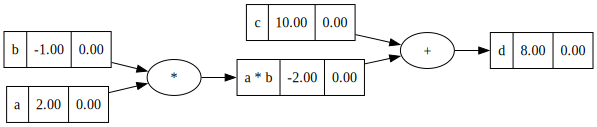

In [676]:
draw(d)

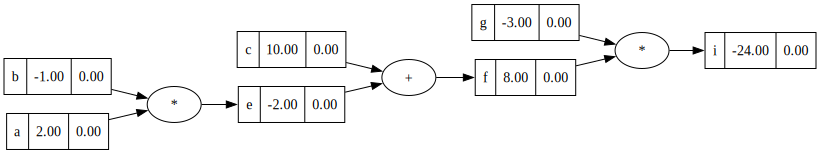

In [677]:
draw(i)

In [678]:
# for funsies: evaluate with graph

def operate(u, v, op):
    if op == '+':
        return u + v
    if op == '*':
        return u * v
    else:
        raise ValueError(f'Unknown operation: {op}')

def evaluate(u):

    print(f'evaluating {u.label}')

    if u._op == '':
        return u.data
    
    pred_values = [evaluate(v) for v in u._pred]
    val = operate(*pred_values, u._op)
    return val

print(evaluate(d))
print(evaluate(i) == i.data)

evaluating d
evaluating c
evaluating a * b
evaluating b
evaluating a
8.0
evaluating i
evaluating g
evaluating f
evaluating c
evaluating e
evaluating b
evaluating a
True


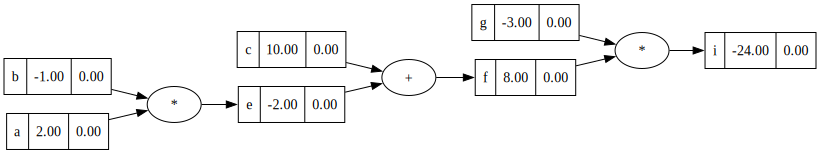

In [679]:
draw(i)

### Getting the gradient by hand

To compute the derivative $\frac{di}{da}$ using the chain rule:

$\frac{di}{da} = \frac{di}{df} \cdot \frac{df}{de} \cdot \frac{de}{da}$

Given: $e = a \cdot b$, $\frac{de}{da} = b$

Given: $f = c + e$, $\frac{df}{de} = 1$

Given: $i = g \cdot f$, $\frac{di}{df} = g$

Thus:
$\frac{di}{da} = g \cdot 1 \cdot b = g \cdot b$

For $g = -3.0$ and $b = -1.0$, $\frac{di}{da} = (-3.0) \cdot (-1.0) = 3$

In [680]:
def numeric_gradient():
    
    h = 0.0000000001

    a = Value(2.0, label = 'a')
    b = Value(-1.0, label = 'b')
    c = Value(10.0, label = 'c') 
    
    e = a * b
    f = e + c
    g = Value(-3.0, label = 'g')
    i = f * g
    L1 = i.data

    a = Value(2.0 + h, label = 'a')
    b = Value(-1.0, label = 'b')
    c = Value(10.0, label = 'c') 
    
    e = a * b
    f = e + c 
    g = Value(-3.0, label = 'g')
    i = f * g
    L2 = i.data

    return (L2 - L1) / h

print(numeric_gradient())

2.999982484652719


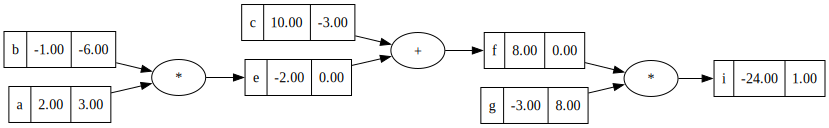

In [681]:
a = Value(2.0, label = 'a', grad=3.0)
b = Value(-1.0, label = 'b', grad=-6.0)
c = Value(10.0, label = 'c', grad=-3.0) 

e = a * b
e.label = 'e'
f = e + c
f.label = 'f'
g = Value(-3.0, label = 'g', grad=8.0)
i = f * g

i.label = 'i'
i.grad = 1.0

draw(i)

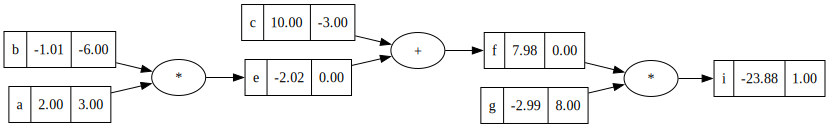

In [682]:
step = 0.001
a.data += a.grad * step
b.data += b.grad * step
c.data += c.grad * step
g.data += g.grad * step

e = a * b
e.label = 'e'
f = e + c
f.label = 'f'
i = f * g

i.label = 'i'
i.grad = 1.0

draw(i)

### Getting gradient with backward()

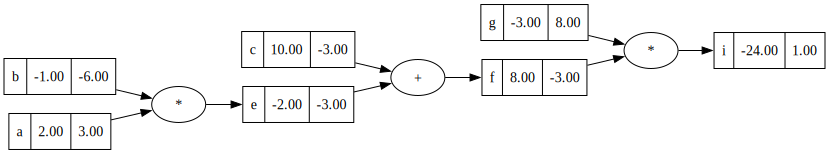

In [683]:
a = Value(2.0, label = 'a')
b = Value(-1.0, label = 'b')
c = Value(10.0, label = 'c') 

e = a * b
e.label = 'e'
f = e + c
f.label = 'f'
g = Value(-3.0, label = 'g')
i = f * g

i.label = 'i'
i.grad = 1.0

i._backward()
g._backward()
f._backward()
e._backward()
a._backward()
b._backward()
c._backward()

draw(i)

### Neuron example

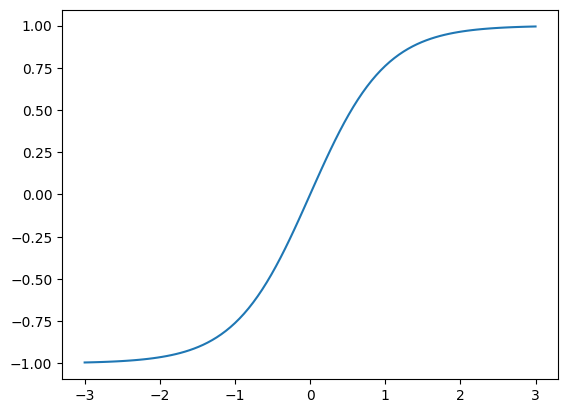

In [684]:
# activation function

X = jnp.linspace(-3, 3, 100)
Y = jnp.tanh(X)

plt.plot(X, Y)

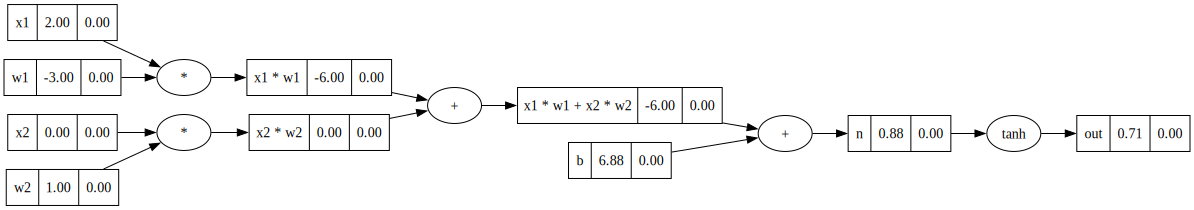

In [685]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias
b = Value(6.88, label = 'b')

# weighted sum + bias (linear combination)
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1x2w2 = x1w1 + x2w2

n = x1w1x2w2 + b
n.label = 'n'

out = n.tanh()
out.label = 'out'

draw(out)


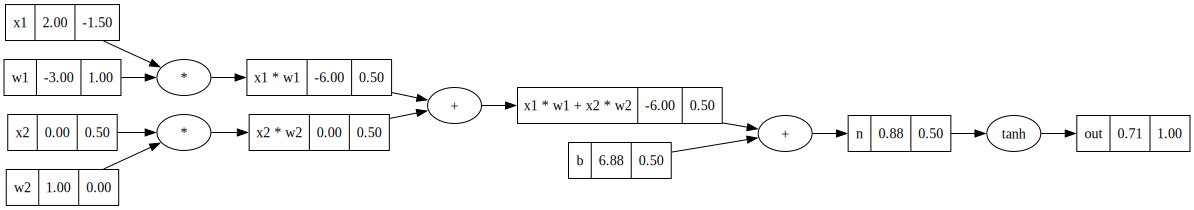

In [686]:
out.grad = 1.0

out._backward()

n._backward()

b._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()

x1._backward()
w1._backward()

x2._backward()
w2._backward()

draw(out)

## Backpropagation

Using topological sort